In [50]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\GOD\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\GOD\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Load the dataset
df = pd.read_csv("resumes.csv")

# Display the first few rows of the dataset
print("First few rows of the dataset:")
print(df.head())

First few rows of the dataset:
                                              Resume Category
0           HR ADMINISTRATOR/MARKETING ASSOCIATE\...       HR
1           HR SPECIALIST, US HR OPERATIONS      ...       HR
2           HR DIRECTOR       Summary      Over 2...       HR
3           HR SPECIALIST       Summary    Dedica...       HR
4           HR MANAGER         Skill Highlights  ...       HR


In [3]:
# Summary statistics
print("\nSummary statistics:")
print(df.describe())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())


Summary statistics:
                                                   Resume Category
count                                               10896    10897
unique                                               5130       67
top     Technical Skills Web Technologies: Angular JS,...       HR
freq                                                   18      484

Missing values:
Resume      1
Category    0
dtype: int64


In [4]:
# Remove missing values
df.dropna(inplace=True)

# Check for duplicates
print("\nNumber of duplicates:")
print(df.duplicated().sum())

In [6]:
# Remove duplicates
df.drop_duplicates(inplace=True)

In [7]:
# Unique values in categorical columns
print("\nUnique values in categorical columns:")
for col in df.select_dtypes(include=['object']):
    print(f"{col}: {df[col].nunique()} unique values")


Unique values in categorical columns:
Resume: 5130 unique values
Category: 67 unique values


In [8]:
# Display the shape of the cleaned dataset
print("Shape of cleaned dataset:", df.shape)

Shape of cleaned dataset: (7480, 2)


In [15]:
def clean_text(text):
    text = str(text)  # Convert to string
    text = re.sub(r'\([^)]*\)', '', text)  # Remove text within parentheses
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetic characters
    text = text.lower()  # Convert to lowercase
    return text

df['cleaned_resume'] = df['Resume'].apply(clean_text)
df['cleaned_category'] = df['Category'].apply(clean_text)
df['tokens'] = df['cleaned_resume'].apply(lambda x: word_tokenize(x))

# Remove stop words
stop_words = set(stopwords.words('english'))
df['tokens'] = df['tokens'].apply(lambda x: [word for word in x if word.lower() not in stop_words])

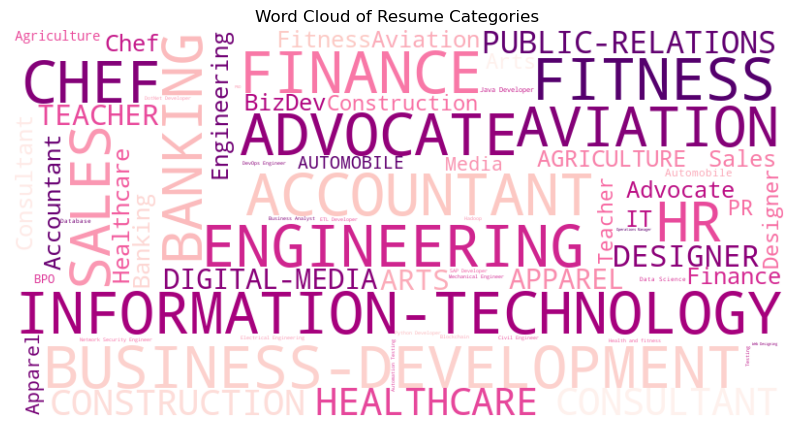

In [19]:
# Count the occurrences of each category
category_counts = df['Category'].value_counts()

# Generate a word cloud based on category frequencies
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='RdPu').generate_from_frequencies(category_counts)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Resume Categories')
plt.axis('off')
plt.show()

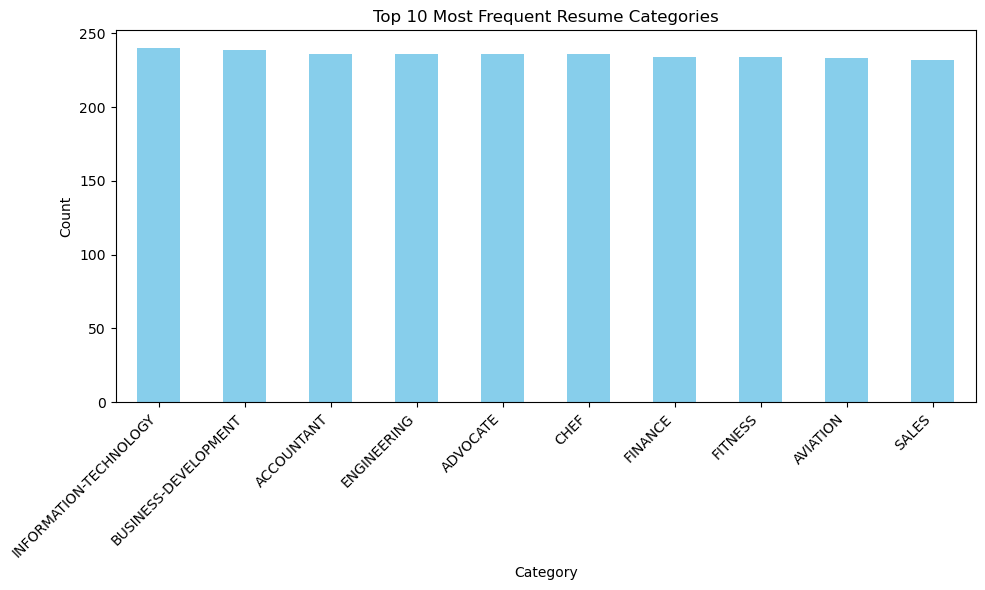

In [22]:
# Select the top N most frequent categories
top_categories = category_counts.nlargest(5).index.tolist()

# Plot the distribution of the top categories
plt.figure(figsize=(10, 6))
category_counts.nlargest(10).plot(kind='bar', color='skyblue')
plt.title('Top 10 Most Frequent Resume Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

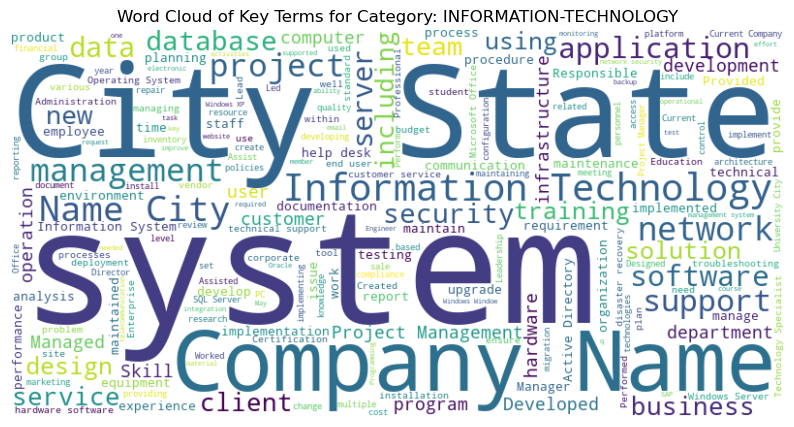

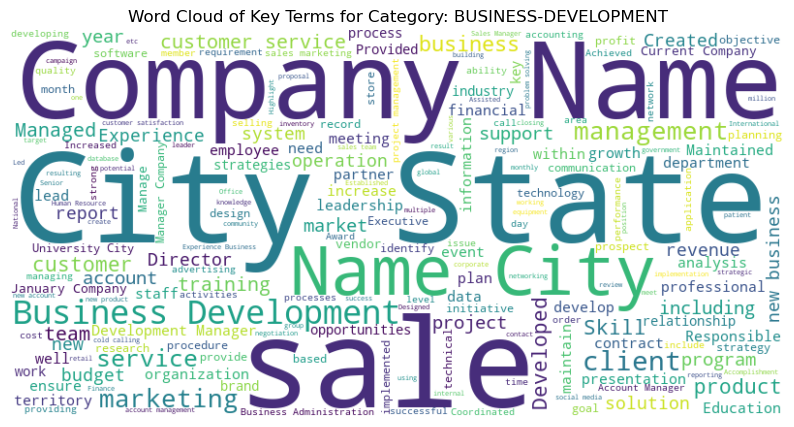

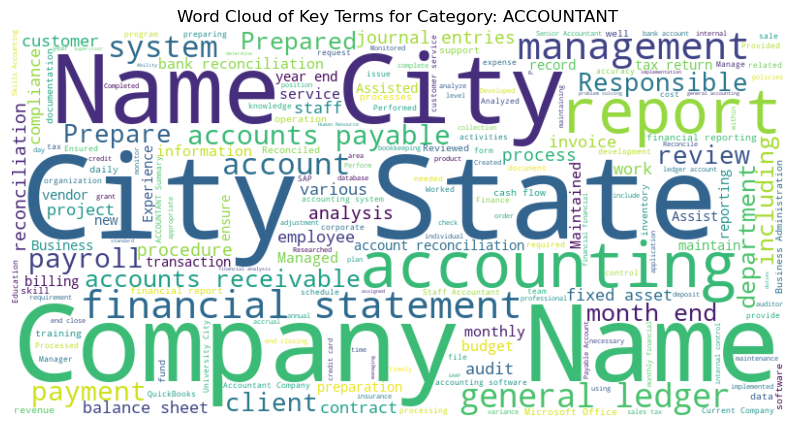

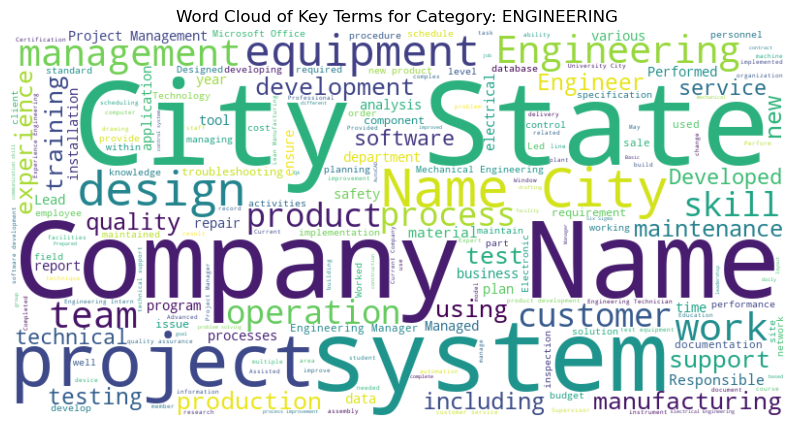

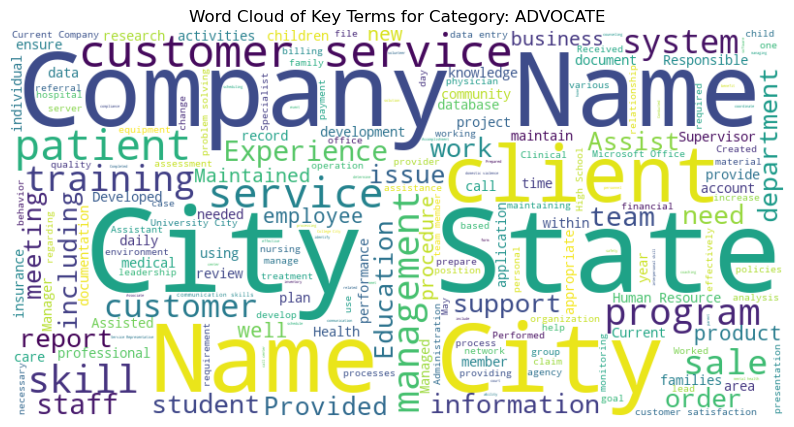

In [23]:
# Extract key terms per category
def extract_key_terms_per_category(category):
    category_df = df[df['Category'] == category]
    all_resumes = ' '.join(category_df['Resume'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_resumes)
    
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud of Key Terms for Category: {category}')
    plt.axis('off')
    plt.show()

# Plot word clouds for key terms in each top category
for category in top_categories:
    extract_key_terms_per_category(category)


In [29]:
# Perform topic modeling on all resume text
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(df['Resume'])

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

# Get top words for each topic
def get_top_words(model, feature_names, n_top_words):
    top_words_per_topic = []
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        top_words_per_topic.append(top_words)
    return top_words_per_topic

# Print top words for each topic
top_words_per_topic = get_top_words(lda, vectorizer.get_feature_names_out(), n_top_words=10)
print("Topics found via LDA:")
for i, top_words in enumerate(top_words_per_topic):
    print(f"Topic #{i+1}: {' '.join(top_words)}")

Topics found via LDA:
Topic #1: state city company students support education training skills systems information
Topic #2: management financial business company accounting state city accounts reports analysis
Topic #3: marketing company sales state city business media management development new
Topic #4: customer state service city company sales skills customers work team
Topic #5: project state city company design management engineering development construction quality


In [32]:
from sklearn.preprocessing import LabelEncoder

# Load the dataset
df = pd.read_csv("resumes.csv")

# Encode the target variable (categories)
label_encoder = LabelEncoder()
df['Category_Encoded'] = label_encoder.fit_transform(df['Category'])

In [38]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['Resume'], df['Category_Encoded'], test_size=0.2, random_state=42)

# Convert all values in 'X_train' and 'X_test' to strings
X_train = X_train.astype(str)
X_test = X_test.astype(str)

# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convert text data to sequences and pad sequences to ensure uniform length
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=200)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=200)

In [48]:
# Define the LSTM model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [49]:
# Train the model
history = model.fit(X_train_seq, y_train, epochs=, batch_size=64, validation_data=(X_test_seq, y_test), callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test_seq, y_test, verbose=0)
print(f"Test Accuracy: {accuracy}")

Epoch 1/15
137/137 ━━━━━━━━━━━━━━━━━━━━ 62s 425ms/step - accuracy: 0.0365 - loss: 4.0251 - val_accuracy: 0.0711 - val_loss: 3.7391
Epoch 2/15
137/137 ━━━━━━━━━━━━━━━━━━━━ 58s 422ms/step - accuracy: 0.0768 - loss: 3.6668 - val_accuracy: 0.1615 - val_loss: 3.2591
Epoch 3/15
137/137 ━━━━━━━━━━━━━━━━━━━━ 82s 419ms/step - accuracy: 0.2157 - loss: 3.1124 - val_accuracy: 0.3486 - val_loss: 2.5850
Epoch 4/15
137/137 ━━━━━━━━━━━━━━━━━━━━ 83s 426ms/step - accuracy: 0.3988 - loss: 2.3666 - val_accuracy: 0.4977 - val_loss: 1.9883
Epoch 5/15
137/137 ━━━━━━━━━━━━━━━━━━━━ 58s 424ms/step - accuracy: 0.5298 - loss: 1.7862 - val_accuracy: 0.5830 - val_loss: 1.5880
Epoch 6/15
137/137 ━━━━━━━━━━━━━━━━━━━━ 82s 422ms/step - accuracy: 0.6050 - loss: 1.4354 - val_accuracy: 0.6445 - val_loss: 1.3184
Epoch 7/15
137/137 ━━━━━━━━━━━━━━━━━━━━ 58s 420ms/step - accuracy: 0.6576 - loss: 1.1945 - val_accuracy: 0.6940 - val_loss: 1.1186
Epoch 8/15
137/137 ━━━━━━━━━━━━━━━━━━━━ 58s 421ms/step - accuracy: 0.6984 - loss: 0

In [52]:
# Save the model using native Keras format
model.save("resume_classification_model.keras")